In [2]:
#Putting All of the Code together
#DATABASE VERSION!!!!

import requests
from bs4 import BeautifulSoup
from datetime import datetime
import re
import csv
from time import sleep
from random import randint
import sqlite3

#Header to buypass any detections, get unique from website https://developers.whatismybrowser.com/
headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36"}

def get_url(JobPosition, Location):
    """Generate a url from position to location"""
    #https://www.indeed.com/jobs?q=Information+Technology&l=Boston%2C+MA&radius=0&remotejob=032b3046-06a3-4876-8dfd-474eb5e7ed11&education=bachelor_degree&vjk=191d9300f5a4206e
    #Create a template so we can input any job search, State and/or City. 022222
    
    #TEMPLATE FOR BOSTON REMOTE JOBS 50 MILES
    templateV = 'https://www.indeed.com/jobs?q={}&l={}&radius=50&remotejob=032b3046-06a3-4876-8dfd-474eb5e7ed11&education=bachelor_degree&vjk=191d9300f5a4206e'
    url = templateV.format(JobPosition, Location)
    return url

#Generalize the modle in a function using OOP
"""Extract job from a single record"""
def get_record(card):
  
    job_title=card.find('h2', {'class': 'jobTitle'}).get_text()
    if job_title[0:3]=='new':
        job_title=job_title[3:]
    company_name = card.find('span', {'class': 'companyName'}).text.strip()
    try:
        rating=card.find('span', 'ratingNumber').get_text()
    except: 
        rating='0.0'
    job_location = (card.find('div', 'companyLocation').text.split()[2]).replace(',','')
    job_summary = card.find('div', 'job-snippet').text.replace('\n', ' ').strip().lower()
    post_date=card.find('span', 'date').get_text()
    if post_date[0:6] == 'Posted':
        post_date=post_date[6:8].strip()
        if post_date[0:]=='Ju':
            post_date= post_date[0:] + '1'
            post_date=post_date[-1:].strip()
        elif post_date[0:]=='To':
            post_date= post_date[0:] + '1'
            post_date=post_date[-1:].strip()
    elif post_date[0:14] == 'EmployerActive':
            post_date= post_date[14:16].strip()
    today = datetime.today().strftime('%Y-%m-%d')
    
    #airtime handling
    try: 
        compensation = card.find('div', 'attribute_snippet').text.strip()
    except:
        compensation = 'null'
        
    record = (job_title, company_name, float(rating), job_location, job_summary, int(post_date), today, compensation)
    
    return record 

def main(position, location):
    """Run the main program routine"""
    records = []
    url = get_url(position, location)
    
    conn = sqlite3.connect('indeeds.db')
    c = conn.cursor()
    
    #If not exist to prevent from OperationalError
    sql_Drop='DROP TABLE IF EXISTS jobtable'
    sql_create='CREATE TABLE jobtable(COMPANYID INTEGER PRIMARY KEY AUTOINCREMENT, JOBTITLE VARCHAR(100), COMPANYNAME VARCHAR(100), RATING FLOAT(5), JOBLOCATION VARCHAR(20), JOBSUMMARY TEXT, POSTDATE INT(5), EXTRACTIONDATE VARCHAR(10), POTENTIALCOMPENSATION VARCHAR(30))'
   
    c.execute(sql_Drop)
    conn.commit()
    c.execute(sql_create)
    conn.commit()
    
    # Getting to the next page 
    for i in range(0, 100):
        response = requests.get(url, headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        cards = soup.find_all('div', 'slider_container')
    
        for card in cards:
            record = get_record(card)
            records.append(record)
            
            title=record[0]
            co_name=record[1]
            rate=record[2]
            location=record[3]
            summary=record[4]
            postdate=record[5]
            extr_date=record[6]
            potential_comp=record[7]
           
            c.execute('INSERT INTO jobtable (JOBTITLE, COMPANYNAME, RATING, JOBLOCATION, JOBSUMMARY, POSTDATE, EXTRACTIONDATE, POTENTIALCOMPENSATION) VALUES(?, ?, ?, ?, ?, ?, ?, ?)', (title, co_name, rate, location, summary, postdate, extr_date, potential_comp))
            conn.commit()
            
            sql_update_rating='Update [jobtable] set [RATING]=NULL WHERE [RATING]= 0.0'
            sql_update_compensation='Update [jobtable] set [POTENTIALCOMPENSATION]=NULL WHERE [POTENTIALCOMPENSATION]="null"'
            
            #print(sql_insert)
            #c.execute(sql_insert)
            #conn.commit()
            c.execute(sql_update_rating)
            conn.commit()
            c.execute(sql_update_compensation)
            conn.commit()
            

        try:
            url = 'https://www.indeed.com' + soup.find('a', {'aria-label': 'Next'}).get('href')
            delay = randint(3, 7)
            sleep(delay)
        except AttributeError:
            break   
    conn.close()



In [4]:
#run the main program to insert position and location into the search boxes on indeed!
main('information technology', 'Boston, MA' )

In [5]:
#Converts database into a csv file
conn = sqlite3.connect('indeeds.db')
c = conn.cursor()
c.execute("select * from jobtable")
with open("dbConvertion.csv", "w", newline='') as csv_file:  # Python 3 version    
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow([i[0] for i in c.description]) # write headers
    csv_writer.writerows(c)

In [6]:
import pandas as pd
import numpy as np
import sqlite3

#Rows returned
pd.set_option('display.max_rows', 9999)

con = sqlite3.connect("indeeds.db")
df = pd.read_sql_query("SELECT JOBTITLE from jobtable2", con)

print(df)

con.close()
# Read sqlite query results into a pandas DataFrame
# Verify that result of SQL query is stored in the dataframe

                                              JOBTITLE
0    Microsoft Office 365 Systems Administrator (Fu...
1                     Sr Network Engineer - CCNP (R&S)
2    Agile IT Audit Co-op - Boston, MA (July - Dece...
3                          IS Business Systems Analyst
4                                Network Administrator
5                   HRIS Analyst - Recruiting (REMOTE)
6                       Application Support Specialist
7    Senior Network Engineer (Base Salary, 20% Bonu...
8                                 IT Auditor (Banking)
9                Junior Cloud One O&S Customer Support
10                  Cyber Security Consultant (remote)
11                          Cyber Threat Hunter Remote
12   Threat Analyst I - Opportunity for Working Rem...
13                  Customer Support Engineer (Remote)
14                     Customer Technical Specialist I
15                    Technical Support Representative
16   Director, Information Technology Applications ...
17        

In [7]:
#Analysis Begins
df.describe()

,JOBTITLE
count,630
unique,481
top,Product Manager
freq,12


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   JOBTITLE  630 non-null    object
dtypes: object(1)
memory usage: 5.0+ KB


In [9]:
#Test
#POS stands for parts of speech!

import nltk
from nltk.corpus import stopwords

#Convert Dataframe into a string
GetAllWords = df.to_string()

# Tokenize each word
AllWordsPOS = nltk.word_tokenize(GetAllWords)
#Test
AllWordsPOS

['JOBTITLE',
 '0',
 'Microsoft',
 'Office',
 '365',
 'Systems',
 'Administrator',
 '(',
 'Fully-remote',
 'pos',
 '...',
 '1',
 'Sr',
 'Network',
 'Engineer',
 '-',
 'CCNP',
 '(',
 'R',
 '&',
 'S',
 ')',
 '2',
 'Agile',
 'IT',
 'Audit',
 'Co-op',
 '-',
 'Boston',
 ',',
 'MA',
 '(',
 'July',
 '-',
 'December',
 '2022',
 ')',
 '3',
 'IS',
 'Business',
 'Systems',
 'Analyst',
 '4',
 'Network',
 'Administrator',
 '5',
 'HRIS',
 'Analyst',
 '-',
 'Recruiting',
 '(',
 'REMOTE',
 ')',
 '6',
 'Application',
 'Support',
 'Specialist',
 '7',
 'Senior',
 'Network',
 'Engineer',
 '(',
 'Base',
 'Salary',
 ',',
 '20',
 '%',
 'Bonus',
 '&',
 'On-Call',
 'pa',
 '...',
 '8',
 'IT',
 'Auditor',
 '(',
 'Banking',
 ')',
 '9',
 'Junior',
 'Cloud',
 'One',
 'O',
 '&',
 'S',
 'Customer',
 'Support',
 '10',
 'Cyber',
 'Security',
 'Consultant',
 '(',
 'remote',
 ')',
 '11',
 'Cyber',
 'Threat',
 'Hunter',
 'Remote',
 '12',
 'Threat',
 'Analyst',
 'I',
 '-',
 'Opportunity',
 'for',
 'Working',
 'Remotely',
 '

In [10]:
#Identifies the parts of speech of each word in the database 
nltk.pos_tag(AllWordsPOS)

[('JOBTITLE', 'NNP'),
 ('0', 'CD'),
 ('Microsoft', 'NNP'),
 ('Office', 'NNP'),
 ('365', 'CD'),
 ('Systems', 'NNP'),
 ('Administrator', 'NNP'),
 ('(', '('),
 ('Fully-remote', 'NNP'),
 ('pos', 'NN'),
 ('...', ':'),
 ('1', 'CD'),
 ('Sr', 'NNP'),
 ('Network', 'NNP'),
 ('Engineer', 'NNP'),
 ('-', ':'),
 ('CCNP', 'NNP'),
 ('(', '('),
 ('R', 'NNP'),
 ('&', 'CC'),
 ('S', 'NNP'),
 (')', ')'),
 ('2', 'CD'),
 ('Agile', 'IN'),
 ('IT', 'NNP'),
 ('Audit', 'NNP'),
 ('Co-op', 'NNP'),
 ('-', ':'),
 ('Boston', 'NNP'),
 (',', ','),
 ('MA', 'NNP'),
 ('(', '('),
 ('July', 'NNP'),
 ('-', ':'),
 ('December', 'NNP'),
 ('2022', 'CD'),
 (')', ')'),
 ('3', 'CD'),
 ('IS', 'NNP'),
 ('Business', 'NNP'),
 ('Systems', 'NNPS'),
 ('Analyst', 'NNP'),
 ('4', 'CD'),
 ('Network', 'NNP'),
 ('Administrator', 'NNP'),
 ('5', 'CD'),
 ('HRIS', 'NNP'),
 ('Analyst', 'NNP'),
 ('-', ':'),
 ('Recruiting', 'NNP'),
 ('(', '('),
 ('REMOTE', 'NNP'),
 (')', ')'),
 ('6', 'CD'),
 ('Application', 'NNP'),
 ('Support', 'NNP'),
 ('Specialist', 

In [11]:
nltk.help.brown_tagset()

(: opening parenthesis
    (
): closing parenthesis
    )
*: negator
    not n't
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ? ; ! :
:: colon
    :
ABL: determiner/pronoun, pre-qualifier
    quite such rather
ABN: determiner/pronoun, pre-quantifier
    all half many nary
ABX: determiner/pronoun, double conjunction or pre-quantifier
    both
AP: determiner/pronoun, post-determiner
    many other next more last former little several enough most least only
    very few fewer past same Last latter less single plenty 'nough lesser
    certain various manye next-to-last particular final previous present
    nuf
AP$: determiner/pronoun, post-determiner, genitive
    other's
AP+AP: determiner/pronoun, post-determiner, hyphenated pair
    many-much
AT: article
    the an no a every th' ever' ye
BE: verb 'to be', infinitive or imperative
    be
BED: verb 'to be', past tense, 2nd person singular or all persons plural
    were
BED*: verb 'to be', past tense, 2nd person singular or 

In [12]:
#Approx. total amount of words collected 
len(GetAllWords)

43538

In [13]:
#Convert Dataframe into a string
GetWords = df.to_string()

#Create a list of all words  
all_words=[]
WordsPOS = nltk.word_tokenize(GetWords)
all_words.extend(WordsPOS)

#puts the most frequent words into a dictionary called freq_dic
freq_dic=nltk.FreqDist(all_words)
print(freq_dic.most_common(10))


[('-', 204), ('Manager', 193), (',', 140), ('(', 129), ('Remote', 124), (')', 120), ('Engineer', 115), ('Product', 104), ('Senior', 99), ('Analyst', 61)]


In [14]:
#Implement stopwords
stopwords=list(set(stopwords.words('english')))

punctuations = [',','.',"'",'"','?','!',";",'’',':','-','...','(',')','Sr.','Sr','I','II','%','&']              
for WordsPOS in stopwords+punctuations:
    if WordsPOS in freq_dic: # WIll take out punctuations and stopwords from most frequent counted words dictionary
        freq_dic.pop(WordsPOS)
print(freq_dic.most_common(50))


[('Manager', 193), ('Remote', 124), ('Engineer', 115), ('Product', 104), ('Senior', 99), ('Analyst', 61), ('Technical', 52), ('Systems', 45), ('Director', 45), ('Project', 45), ('Security', 44), ('Support', 40), ('IT', 38), ('Architect', 34), ('Technology', 30), ('Management', 30), ('REMOTE', 29), ('Consultant', 28), ('Lead', 26), ('Specialist', 25), ('Software', 25), ('Program', 25), ('Engineering', 24), ('Associate', 23), ('US', 23), ('Cloud', 22), ('Customer', 22), ('Information', 22), ('Administrator', 20), ('Business', 19), ('Opportunity', 19), ('Application', 16), ('Cyber', 15), ('Solutions', 15), ('Risk', 14), ('Digital', 14), ('Developer', 14), ('Principal', 14), ('Implementation', 14), ('Enterprise', 13), ('Data', 13), ('System', 13), ('Applications', 12), ('Operations', 12), ('PwC', 12), ('Compliance', 11), ('Network', 10), ('remote', 10), ('Success', 10), ('Salesforce', 10)]


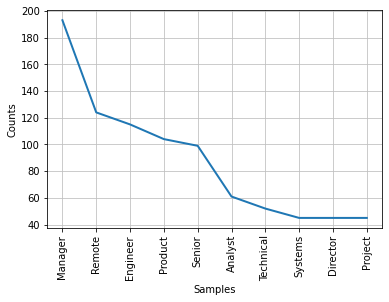

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [17]:
#Frequency distribution for the top 10 words
fd1 = freq_dic
fd1.plot(10)

In [15]:
#Test for jobtitles
GetWords

"                                                            JOBTITLE\n0    Microsoft Office 365 Systems Administrator (Fully-remote pos...\n1                                   Sr Network Engineer - CCNP (R&S)\n2           Agile IT Audit Co-op - Boston, MA (July - December 2022)\n3                                        IS Business Systems Analyst\n4                                              Network Administrator\n5                                 HRIS Analyst - Recruiting (REMOTE)\n6                                     Application Support Specialist\n7    Senior Network Engineer (Base Salary, 20% Bonus & On-Call pa...\n8                                               IT Auditor (Banking)\n9                              Junior Cloud One O&S Customer Support\n10                                Cyber Security Consultant (remote)\n11                                        Cyber Threat Hunter Remote\n12    Threat Analyst I - Opportunity for Working Remotely Boston,...\n13                 

In [16]:

#Takes the str dataframe a counts all of the diffrent parts of speech 
from collections import Counter
from nltk import FreqDist
import nltk

text = GetWords
lower_case = text.lower()
tokens = nltk.word_tokenize(lower_case)
tags = nltk.pos_tag(tokens)
counts = Counter( tag for word,  tag in tags)
print(counts)

Counter({'NN': 1731, 'CD': 645, 'JJ': 500, ':': 264, 'NNS': 169, ',': 140, '(': 129, ')': 120, 'VBP': 67, 'PRP': 61, 'VB': 57, 'CC': 54, 'IN': 41, 'SYM': 32, 'VBD': 29, 'RB': 26, 'VBZ': 20, 'VBG': 17, 'NNP': 13, 'VBN': 12, 'TO': 7, 'MD': 5, 'JJS': 5, '$': 2, 'JJR': 1, 'POS': 1, '.': 1, 'FW': 1})


In [18]:
#Returns most commons words 
fd1.most_common(10)

[('Manager', 193),
 ('Remote', 124),
 ('Engineer', 115),
 ('Product', 104),
 ('Senior', 99),
 ('Analyst', 61),
 ('Technical', 52),
 ('Systems', 45),
 ('Director', 45),
 ('Project', 45)]

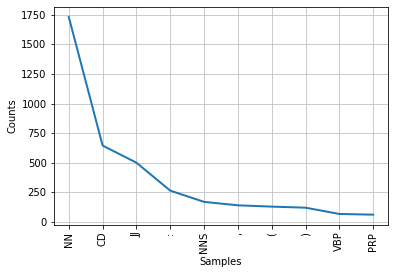

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [19]:
#Frequency distribution for POS
words = counts
fd2 = nltk.FreqDist(words)
fd2.plot(10)

In [20]:
#Returns most commons POS 
fd2.most_common(10)

[('NN', 1731),
 ('CD', 645),
 ('JJ', 500),
 (':', 264),
 ('NNS', 169),
 (',', 140),
 ('(', 129),
 (')', 120),
 ('VBP', 67),
 ('PRP', 61)]

In [21]:
#Bigrams combination of two words discovered multiple times in document
#Trigramscombinationof three words discovered multiple times in document

Tokens = nltk.word_tokenize(text)
bigrams = list(nltk.bigrams(Tokens))
trigrams = list(nltk.trigrams(Tokens))
bigrams

[('JOBTITLE', '0'),
 ('0', 'Microsoft'),
 ('Microsoft', 'Office'),
 ('Office', '365'),
 ('365', 'Systems'),
 ('Systems', 'Administrator'),
 ('Administrator', '('),
 ('(', 'Fully-remote'),
 ('Fully-remote', 'pos'),
 ('pos', '...'),
 ('...', '1'),
 ('1', 'Sr'),
 ('Sr', 'Network'),
 ('Network', 'Engineer'),
 ('Engineer', '-'),
 ('-', 'CCNP'),
 ('CCNP', '('),
 ('(', 'R'),
 ('R', '&'),
 ('&', 'S'),
 ('S', ')'),
 (')', '2'),
 ('2', 'Agile'),
 ('Agile', 'IT'),
 ('IT', 'Audit'),
 ('Audit', 'Co-op'),
 ('Co-op', '-'),
 ('-', 'Boston'),
 ('Boston', ','),
 (',', 'MA'),
 ('MA', '('),
 ('(', 'July'),
 ('July', '-'),
 ('-', 'December'),
 ('December', '2022'),
 ('2022', ')'),
 (')', '3'),
 ('3', 'IS'),
 ('IS', 'Business'),
 ('Business', 'Systems'),
 ('Systems', 'Analyst'),
 ('Analyst', '4'),
 ('4', 'Network'),
 ('Network', 'Administrator'),
 ('Administrator', '5'),
 ('5', 'HRIS'),
 ('HRIS', 'Analyst'),
 ('Analyst', '-'),
 ('-', 'Recruiting'),
 ('Recruiting', '('),
 ('(', 'REMOTE'),
 ('REMOTE', ')'),
 

In [22]:
trigrams

[('JOBTITLE', '0', 'Microsoft'),
 ('0', 'Microsoft', 'Office'),
 ('Microsoft', 'Office', '365'),
 ('Office', '365', 'Systems'),
 ('365', 'Systems', 'Administrator'),
 ('Systems', 'Administrator', '('),
 ('Administrator', '(', 'Fully-remote'),
 ('(', 'Fully-remote', 'pos'),
 ('Fully-remote', 'pos', '...'),
 ('pos', '...', '1'),
 ('...', '1', 'Sr'),
 ('1', 'Sr', 'Network'),
 ('Sr', 'Network', 'Engineer'),
 ('Network', 'Engineer', '-'),
 ('Engineer', '-', 'CCNP'),
 ('-', 'CCNP', '('),
 ('CCNP', '(', 'R'),
 ('(', 'R', '&'),
 ('R', '&', 'S'),
 ('&', 'S', ')'),
 ('S', ')', '2'),
 (')', '2', 'Agile'),
 ('2', 'Agile', 'IT'),
 ('Agile', 'IT', 'Audit'),
 ('IT', 'Audit', 'Co-op'),
 ('Audit', 'Co-op', '-'),
 ('Co-op', '-', 'Boston'),
 ('-', 'Boston', ','),
 ('Boston', ',', 'MA'),
 (',', 'MA', '('),
 ('MA', '(', 'July'),
 ('(', 'July', '-'),
 ('July', '-', 'December'),
 ('-', 'December', '2022'),
 ('December', '2022', ')'),
 ('2022', ')', '3'),
 (')', '3', 'IS'),
 ('3', 'IS', 'Business'),
 ('IS', '

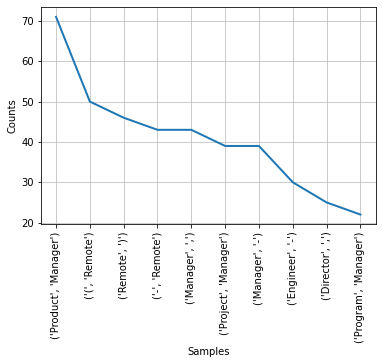

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [23]:
#Frequency distribution for the top 10 bigrams collected
fd = nltk.FreqDist(bigrams)
fd.plot(10)

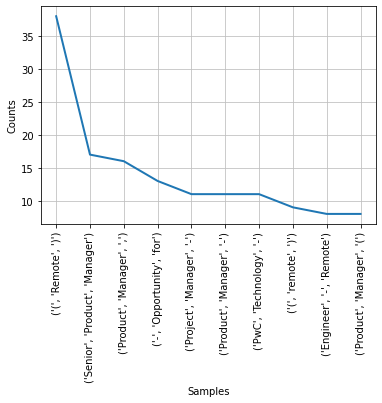

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [24]:
#Frequency distribution for the top 10 trigrams collected
fd = nltk.FreqDist(trigrams)
fd.plot(10)